##### Copyright 2025 Google LLC.

In [2]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 🚀 Memory Management - Part 1 - Sessions

**Welcome to Day 3 of the Kaggle 5-day Agents course!**

In this notebook, you'll learn:

- ✅ What sessions are and how to use them in your agent
- ✅ How to build *stateful* agents with sessions and events
- ✅ How to persist sessions in a database
- ✅ Context management practices such as context compaction
- ✅ Best practices for sharing session State

## ‼️ Please Read


> ❌ **ℹ️ Note: No submission required!**
> This notebook is for your hands-on practice and learning only. You **do not** need to submit it anywhere to complete the course.

> ⏸️ **Note:**  When you first start the notebook via running a cell you might see a banner in the notebook header that reads **"Waiting for the next available notebook"**. The queue should drop rapidly; however, during peak bursts you might have to wait a few minutes.

> ❌ **Note:** Avoid using the **Run all** cells command as this can trigger a QPM limit resulting in 429 errors when calling the backing model. Suggested flow is to run each cell in order - one at a time. [See FAQ on 429 errors for more information.](https://www.kaggle.com/code/kaggle5daysofai/day-0-troubleshooting-and-faqs)

**For help: Ask questions on the [Kaggle Discord](https://discord.com/invite/kaggle) server.**

## 📖 Get started with Kaggle Notebooks

If this is your first time using Kaggle Notebooks, welcome! You can learn more about using Kaggle Notebooks [in the documentation](https://www.kaggle.com/docs/notebooks).

Here's how to get started:

**1. Verify Your Account (Required)**

To use the Kaggle Notebooks in this course, you'll need to verify your account with a phone number.

You can do this in your [Kaggle settings](https://www.kaggle.com/settings).

**2. Make Your Own Copy**

To run any code in this notebook, you first need your own editable copy.

Click the `Copy and Edit` button in the top-right corner.

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

This creates a private copy of the notebook just for you.

**3. Run Code Cells**

Once you have your copy, you can run code.

Click the ▶️ Run button next to any code cell to execute it.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

Run the cells in order from top to bottom.

**4. If You Get Stuck**

To restart: Select `Factory reset` from the `Run` menu.

For help: Ask questions on the [Kaggle Discord](https://discord.com/invite/kaggle) server.

---
## ⚙️ Section 1: Setup

### 1.1: Install dependencies

The Kaggle Notebooks environment includes a pre-installed version of the [google-adk](https://google.github.io/adk-docs/) library for Python and its required dependencies, so you don't need to install additional packages in this notebook.

To install and use ADK in your own Python development environment outside of this course, you can do so by running:

```
pip install google-adk
```

### 1.2: Configure your Gemini API Key

This notebook uses the [Gemini API](https://ai.google.dev/gemini-api/docs), which requires authentication.

**1. Get your API key**

If you don't have one already, create an [API key in Google AI Studio](https://aistudio.google.com/app/api-keys).

**2. Add the key to Kaggle Secrets**

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

1. In the top menu bar of the notebook editor, select `Add-ons` then `Secrets`.
2. Create a new secret with the label `GOOGLE_API_KEY`.
3. Paste your API key into the "Value" field and click "Save".
4. Ensure that the checkbox next to `GOOGLE_API_KEY` is selected so that the secret is attached to the notebook.

**3. Authenticate in the notebook**

Run the cell below to complete authentication.

In [3]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


### 1.3: Import ADK components

Now, import the specific components you'll need from the Agent Development Kit and the Generative AI library. This keeps your code organized and ensures we have access to the necessary building blocks.

In [5]:
from typing import Any, Dict

from google.adk.agents import Agent, LlmAgent
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.models.google_llm import Gemini
from google.adk.sessions import DatabaseSessionService
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


### 1.4: Helper functions

Helper function that manages a complete conversation session, handling session
creation/retrieval, query processing, and response streaming. It supports
both single queries and multiple queries in sequence.

Example:

```
>>> await run_session(runner, "What is the capital of France?", "geography-session")
>>> await run_session(runner, ["Hello!", "What's my name?"], "user-intro-session")
```

In [6]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


print("✅ Helper functions defined.")

✅ Helper functions defined.


### 1.5: Configure Retry Options

When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [7]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

---
## 🤹 Section 2: Session Management

### 2.1 The Problem

At their core, Large Language Models are **inherently stateless**. Their awareness is confined to the information you provide in a single API call. This means an agent without proper context management will react to the current prompt without considering any previous history.

**❓ Why does this matter?** Imagine trying to have a meaningful conversation with someone who forgets everything you've said after each sentence. That's the challenge we face with raw LLMs!

In ADK, we use `Sessions` for **short term memory management** and `Memory` for **long term memory.** In the next notebook, you'll focus on `Memory`.

### 2.2 What is a Session?

#### **📦 Session**

A session is a container for conversations. It encapsulates the conversation history in a chronological manner and also records all tool interactions and responses for a **single, continuous conversation**. A session is tied to a user and agent; it is not shared with other users. Similarly, a session history for an Agent is not shared with other Agents.

In ADK, a **Session** is comprised of two key components `Events` and `State`:

**📝 Session.Events**:

> While a session is a container for conversations, `Events` are the building blocks of a conversation.
>
> Example of Events:
> - *User Input*: A message from the user (text, audio, image, etc.)
> - *Agent Response*: The agent's reply to the user
> - *Tool Call*: The agent's decision to use an external tool or API
> - *Tool Output*: The data returned from a tool call, which the agent uses to continue its reasoning
    

**{} Session.State**:

> `session.state` is the Agent's scratchpad, where it stores and updates dynamic details needed during the conversation. Think of it as a global `{key, value}` pair storage which is available to all subagents and tools.

<img src="https://storage.googleapis.com/github-repo/kaggle-5days-ai/day3/session-state-and-events.png" width="320" alt="Session state and events">

<!-- ```mermaid
graph TD
    subgraph A["Agentic Application"];
        subgraph U["User"]
            subgraph S1["Session"]
                D1["Session.Events"]
                D2["Session.State"]
            end
        end
    end
``` -->

### 2.3 How to manage sessions?

An agentic application can have multiple users and each user may have multiple sessions with the application.
To manage these sessions and events, ADK offers a **Session Manager** and **Runner**.

1. **`SessionService`**: The storage layer
   - Manages creation, storage, and retrieval of session data
   - Different implementations for different needs (memory, database, cloud)

2. **`Runner`**: The orchestration layer
   - Manages the flow of information between user and agent
   - Automatically maintains conversation history
   - Handles the Context Engineering behind the scenes

Think of it like this:

- **Session** = A notebook 📓
- **Events** = Individual entries in a single page 📝
- **SessionService** = The filing cabinet storing notebooks 🗄️
- **Runner** = The assistant managing the conversation 🤖

### 2.4 Implementing Our First Stateful Agent

Let's build our first stateful agent, that can remember and have constructive conversations. 

ADK offers different types of sessions suitable for different needs. As a start, we'll start with a simple Session Management option (`InMemorySessionService`):

In [8]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

MODEL_NAME = "gemini-2.5-flash-lite"


# Step 1: Create the LLM Agent
root_agent = Agent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="A text chatbot",  # Description of the agent's purpose
)

# Step 2: Set up Session Management
# InMemorySessionService stores conversations in RAM (temporary)
session_service = InMemorySessionService()

# Step 3: Create the Runner
runner = Runner(agent=root_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Stateful agent initialized!")
print(f"   - Application: {APP_NAME}")
print(f"   - User: {USER_ID}")
print(f"   - Using: {session_service.__class__.__name__}")

✅ Stateful agent initialized!
   - Application: default
   - User: default
   - Using: InMemorySessionService


### 2.5 Testing Our Stateful Agent

Now let's see the magic of sessions in action!

In [9]:
# Run a conversation with two queries in the same session
# Notice: Both queries are part of the SAME session, so context is maintained
await run_session(
    runner,
    [
        "Hi, I am Sam! What is the capital of United States?",
        "Hello! What is my name?",  # This time, the agent should remember!
    ],
    "stateful-agentic-session",
)


 ### Session: stateful-agentic-session

User > Hi, I am Sam! What is the capital of United States?
gemini-2.5-flash-lite >  Hi Sam! The capital of the United States is Washington, D.C.

User > Hello! What is my name?
gemini-2.5-flash-lite >  Your name is Sam! 😊


🎉 **Success!** The agent remembered your name because both queries were part of the same session. The Runner automatically maintained the conversation history.

But there's a catch: `InMemorySessionService` is temporary. **Once the application stops, all conversation history is lost.** 


### 🛑 (Optional) 2.6 Testing Agent's forgetfulness (didn't run this)


> To verify that the agent forgets the conversation, **restart the kernel**. Then, **run ALL the previous cells in this notebook EXCEPT the `run_session` in 2.5.**
> 
> Now run the cell below. You'll see that the agent doesn't remember anything from the previous conversation.
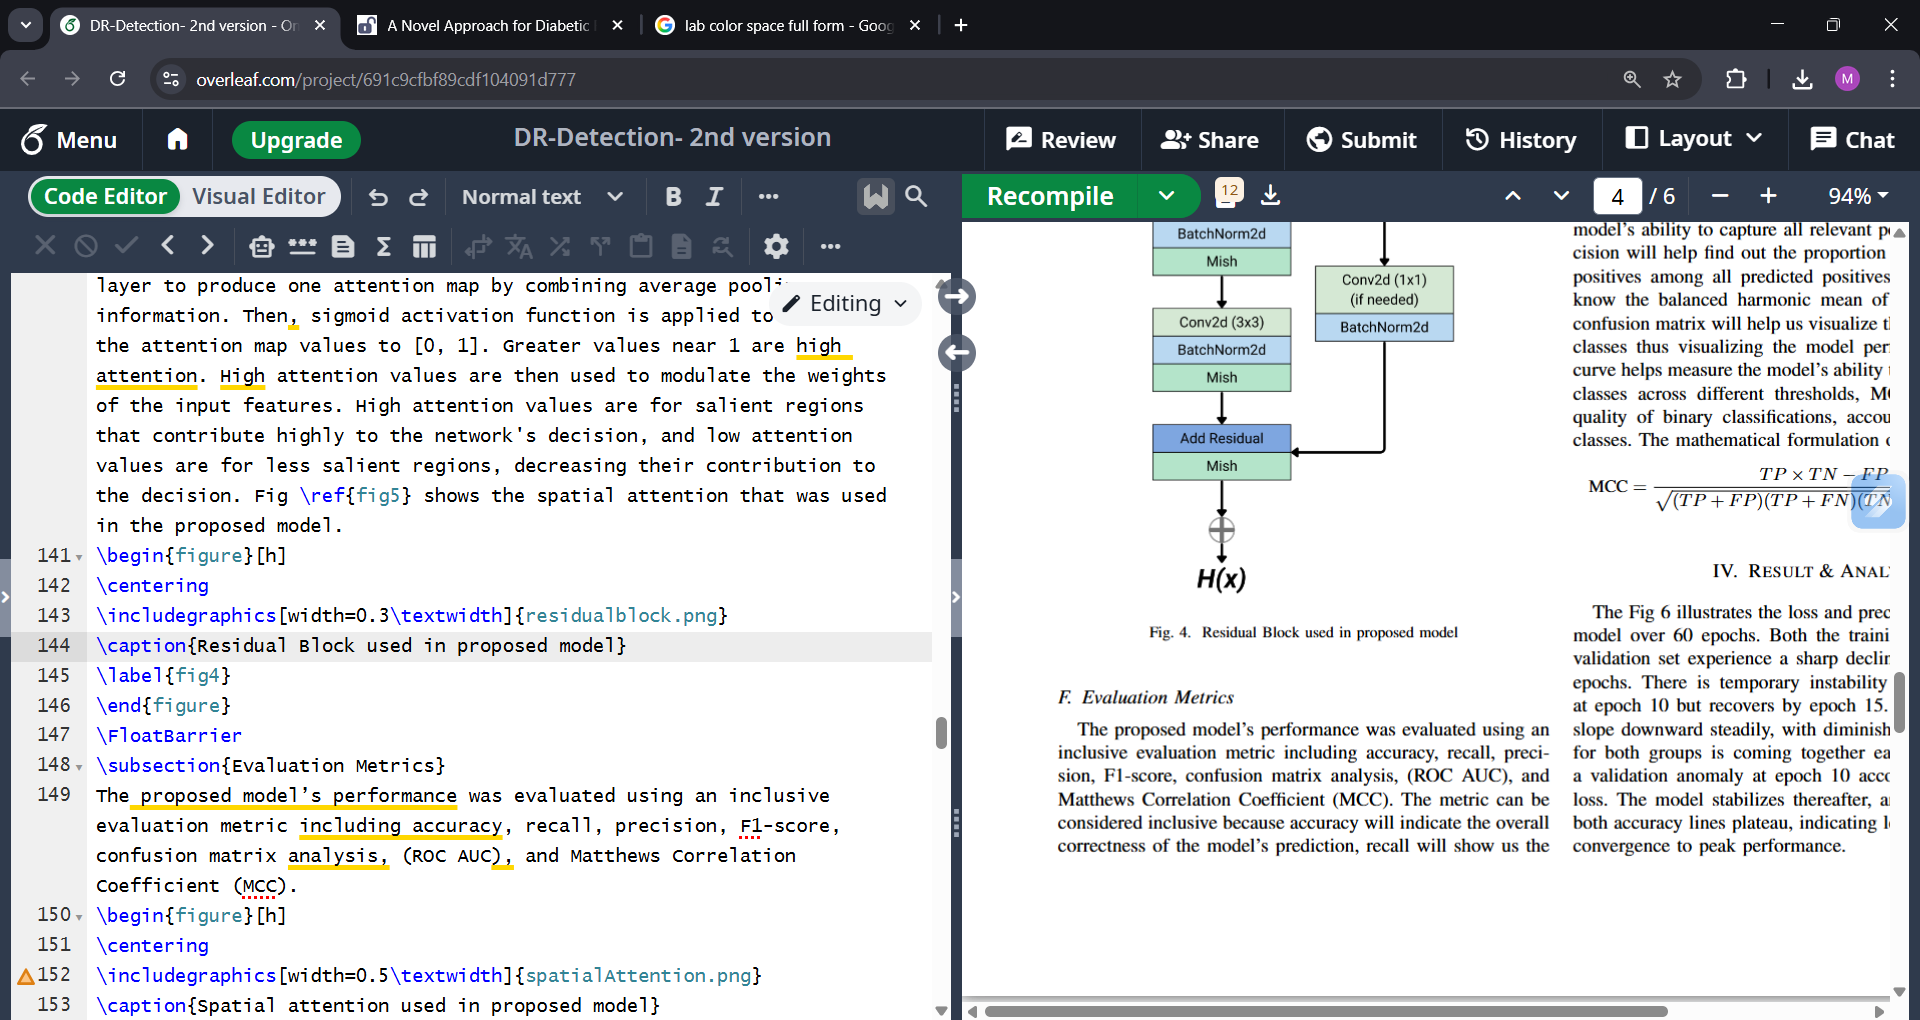

In [11]:
# Run this cell after restarting the kernel. All this history will be gone...
await run_session(
    runner,
    ["What did I ask you about earlier?", "And remind me, what's my name?"],
    "stateful-agentic-session",
)  # Note, we are using same session name


 ### Session: stateful-agentic-session

User > What did I ask you about earlier?
gemini-2.5-flash-lite >  You asked me about the capital of the United States earlier, and then you reminded me of your name.

User > And remind me, what's my name?
gemini-2.5-flash-lite >  Your name is Sam!


### The Problem

Session information is not persistent (i.e., meaningful conversations are lost). While this is advantageous in testing environments, **in the real world, a user should be able to refer from past and resume conversations.** To achieve this, we must persist information. 

---
## 📈 Section 3: Persistent Sessions with `DatabaseSessionService`

While `InMemorySessionService` is great for prototyping, real-world applications need conversations to survive restarts, crashes, and deployments. Let's level up to persistent storage!

### 3.1 Choosing the Right SessionService

ADK provides different SessionService implementations for different needs:

| Service | Use Case | Persistence | Best For |
|---------|----------|-------------|----------|
| **InMemorySessionService** | Development & Testing | ❌ Lost on restart | Quick prototypes |
| **DatabaseSessionService** | Self-managed apps | ✅ Survives restarts | Small to medium apps |
| **Agent Engine Sessions** | Production on GCP | ✅ Fully managed | Enterprise scale |


### 3.2 Implementing Persistent Sessions

Let's upgrade to `DatabaseSessionService` using SQLite. This gives us persistence without needing a separate database server for this demo.

Let's create a `chatbot_agent` capable of having a conversation with the user.

In [13]:
# Step 1: Create the same agent (notice we use LlmAgent this time)
chatbot_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="A text chatbot with persistent memory",
)

# Step 2: Switch to DatabaseSessionService
# SQLite database will be created automatically
db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Step 3: Create a new runner with persistent storage
runner = Runner(agent=chatbot_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Upgraded to persistent sessions!")
print(f"   - Database: my_agent_data.db")
print(f"   - Sessions will survive restarts!")

✅ Upgraded to persistent sessions!
   - Database: my_agent_data.db
   - Sessions will survive restarts!


### 3.3 Test Run 1: Verifying Persistence

In this first test run, we'll start a new conversation with the session ID `test-db-session-01`. We will first introduce our name as 'Sam' and then ask a question. In the second turn, we will ask the agent for our name.

Since we are using `DatabaseSessionService`, the agent should remember the name.

After the conversation, we'll inspect the `my_agent_data.db` SQLite database directly to see how the conversation `events` (the user queries and model responses) are stored.


In [14]:
await run_session(
    runner,
    ["Hi, I am Sam! What is the capital of the United States?", "Hello! What is my name?"],
    "test-db-session-01",
)


 ### Session: test-db-session-01

User > Hi, I am Sam! What is the capital of the United States?
gemini-2.5-flash-lite >  Hi Sam! The capital of the United States is Washington, D.C.

User > Hello! What is my name?
gemini-2.5-flash-lite >  Your name is Sam.


### 🛑 (Optional) 3.4 Test Run 2: Resuming a Conversation

> ‼️ Now, let's repeat the test again, but this time, **let's stop this Kaggle Notebook's kernel and restart it again.**
>
> 1. Run all the previous cells in the notebook, **EXCEPT** the previous Section 3.3 (`run_session` cell).
>
> 2. Now, run the below cell with the **same session ID** (`test-db-session-01`).

We will ask a new question and then ask for our name again. **Because the session is loaded from the database, the agent should still remember** that our name is 'Sam' from the first test run. This demonstrates the power of persistent sessions.


In [15]:
await run_session(
    runner,
    ["What is the capital of India?", "Hello! What is my name?"],
    "test-db-session-01",
)


 ### Session: test-db-session-01

User > What is the capital of India?
gemini-2.5-flash-lite >  The capital of India is New Delhi.

User > Hello! What is my name?
gemini-2.5-flash-lite >  Your name is Sam.


### 3.5 Let's verify that the session data is isolated

As mentioned earlier, a session is private conversation between an Agent and a User (i.e., two sessions do not share information). Let's run our `run_session` with a different session name `test-db-session-02` to confirm this.


In [16]:
await run_session(
    runner, ["Hello! What is my name?"], "test-db-session-02"
)  # Note, we are using new session name


 ### Session: test-db-session-02

User > Hello! What is my name?
gemini-2.5-flash-lite >  I do not have access to your personal information, including your name. I am a text-based chatbot and do not have the ability to store or recall personal details about users.


### 3.6 How are the events stored in the Database?

Since we are using a sqlite DB to store information, let's have a quick peek to see how information is stored.

In [17]:
import sqlite3

def check_data_in_db():
    with sqlite3.connect("my_agent_data.db") as connection:
        cursor = connection.cursor()
        result = cursor.execute(
            "select app_name, session_id, author, content from events"
        )
        print([_[0] for _ in result.description])
        for each in result.fetchall():
            print(each)


check_data_in_db()

['app_name', 'session_id', 'author', 'content']
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hi, I am Sam! What is the capital of the United States?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "Hi Sam! The capital of the United States is Washington, D.C."}], "role": "model"}')
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hello! What is my name?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "Your name is Sam."}], "role": "model"}')
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "What is the capital of India?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": "The capital of India is New Delhi."}], "role": "model"}')
('default', 'test-db-session-01', 'user', '{"parts": [{"text": "Hello! What is my name?"}], "role": "user"}')
('default', 'test-db-session-01', 'text_chat_bot', '{"parts": [{"text": 

---
## ⏳ Section 4: Context Compaction

As you can see, all the events are stored in full in the session Database, and this quickly adds up. For a long, complex task, this list of events can become very large, leading to slower performance and higher costs.

But what if we could automatically summarize the past? Let's use ADK's **Context Compaction** feature to see **how to automatically reduce the context that's stored in the Session.**

<img src="https://storage.googleapis.com/github-repo/kaggle-5days-ai/day3/context-compaction.png" width="1400" alt="Context compaction">

### 4.1 Create an App for the agent

To enable this feature, let's use the same `chatbot_agent` we created in Section 3.2. 

The first step is to create an object called `App`. We'll give it a name and pass in our chatbot_agent. 

We'll also create a new config to do the Context Compaction. This **`EventsCompactionConfig`** defines two key variables:

- **compaction_interval**: Asks the Runner to compact the history after every `n` conversations
- **overlap_size**: Defines the number of previous conversations to retain for overlap

We'll then provide this app to the Runner.


In [18]:
# Re-define our app with Events Compaction enabled
research_app_compacting = App(
    name="research_app_compacting",
    root_agent=chatbot_agent,
    # This is the new part!
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=3,  # Trigger compaction every 3 invocations
        overlap_size=1,  # Keep 1 previous turn for context
    ),
)

db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Create a new runner for our upgraded app
research_runner_compacting = Runner(
    app=research_app_compacting, session_service=session_service
)


print("✅ Research App upgraded with Events Compaction!")

✅ Research App upgraded with Events Compaction!


/tmp/ipykernel_48/3773147741.py:6: UserWarning: [EXPERIMENTAL] EventsCompactionConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  events_compaction_config=EventsCompactionConfig(


### 4.2 Running the Demo

Now, let's have a conversation that is long enough to trigger the compaction. When you run the cell below, the output will look like a normal conversation. However, because we configured our `App`, a compaction process will run silently in the background after the 3rd invocation.

In the next step, we'll prove that it happened.

In [19]:
# Turn 1
await run_session(
    research_runner_compacting,
    "What is the latest news about AI in healthcare?",
    "compaction_demo",
)

# Turn 2
await run_session(
    research_runner_compacting,
    "Are there any new developments in drug discovery?",
    "compaction_demo",
)

# Turn 3 - Compaction should trigger after this turn!
await run_session(
    research_runner_compacting,
    "Tell me more about the second development you found.",
    "compaction_demo",
)

# Turn 4
await run_session(
    research_runner_compacting,
    "Who are the main companies involved in that?",
    "compaction_demo",
)


 ### Session: compaction_demo

User > What is the latest news about AI in healthcare?
gemini-2.5-flash-lite >  The field of AI in healthcare is constantly evolving, so "latest" can be a moving target! However, here are some of the most significant and recent trends and developments:

**1. Generative AI for Drug Discovery and Development:**
*   **Accelerated Discovery:** Companies are increasingly using generative AI models to design novel drug candidates, predict their properties, and optimize their structure. This can drastically reduce the time and cost of traditional drug discovery.
*   **Personalized Therapies:** Generative AI is also being explored for designing personalized treatments based on an individual's genetic makeup, disease profile, and response to previous therapies.
*   **Examples:** Companies like Recursion Pharmaceuticals, Insilico Medicine, and Exscientia are heavily invested in this area.

**2. AI for Diagnostics and Imaging:**
*   **Improved Accuracy and Speed:**

### 4.3 Verifying Compaction in the Session History

The conversation above looks normal, but the history has been changed behind the scenes. How can we prove it?

We can inspect the `events` list from our session. The compaction process **doesn't delete old events; it replaces them with a single, new `Event` that contains the summary.** Let's find it.

In [20]:
# Get the final session state
final_session = await session_service.get_session(
    app_name=research_runner_compacting.app_name,
    user_id=USER_ID,
    session_id="compaction_demo",
)

print("--- Searching for Compaction Summary Event ---")
found_summary = False
for event in final_session.events:
    # Compaction events have a 'compaction' attribute
    if event.actions and event.actions.compaction:
        print("\n✅ SUCCESS! Found the Compaction Event:")
        print(f"  Author: {event.author}")
        print(f"\n Compacted information: {event}")
        found_summary = True
        break

if not found_summary:
    print(
        "\n❌ No compaction event found. Try increasing the number of turns in the demo."
    )

--- Searching for Compaction Summary Event ---

✅ SUCCESS! Found the Compaction Event:
  Author: user

 Compacted information: model_version=None content=None grounding_metadata=None partial=None turn_complete=None finish_reason=None error_code=None error_message=None interrupted=None custom_metadata=None usage_metadata=None live_session_resumption_update=None input_transcription=None output_transcription=None avg_logprobs=None logprobs_result=None cache_metadata=None citation_metadata=None invocation_id='4da7a30d-4854-46eb-8978-176989137e62' author='user' actions=EventActions(skip_summarization=None, state_delta={}, artifact_delta={}, transfer_to_agent=None, escalate=None, requested_auth_configs={}, requested_tool_confirmations={}, compaction={'start_timestamp': 1763718905.247968, 'end_timestamp': 1763718919.736191, 'compacted_content': {'parts': [{'function_call': None, 'code_execution_result': None, 'executable_code': None, 'file_data': None, 'function_response': None, 'inline_data'

### 4.4 What you've accomplished: Automatic Context Management

You just found the proof! The presence of that special summary `Event` in your session's history is the tangible result of the compaction process.

**Let's recap what you just witnessed:**

1.  **Silent Operation**: You ran a standard conversation, and from the outside, nothing seemed different.
2.  **Background Compaction**: Because you configured the `App` with `EventsCompactionConfig`, the ADK `Runner` automatically monitored the conversation length. Once the threshold was met, it triggered the summarization process in the background.
3.  **Verified Result**: By inspecting the session's events, you found the summary that the LLM generated. This summary now replaces the older, more verbose turns in the agent's active context.

**For all future turns in this conversation, the agent will be given this concise summary instead of the full history.** This saves costs, improves performance, and helps the agent stay focused on what's most important.


### 4.5 More Context Engineering options in ADK

#### 👉 Custom Compaction
In this example, we used ADK's default summarizer. For more advanced use cases, you can provide your own by defining a custom `SlidingWindowCompactor` and passing it to the config. This allows you to control the summarization prompt or even use a different, specialized LLM for the task. You can read more about it in the [official documentation](https://google.github.io/adk-docs/context/compaction/).

#### 👉 Context Caching
ADK also provides **Context Caching** to help reduce the token size of the static instructions that are fed to the LLM by caching the request data. Read more about it [here](https://google.github.io/adk-docs/context/caching/).

### The Problem

While we can do Context Compaction and use a database to resume a session, we face new challenges now. In some cases, **we have key information or preferences that we want to share across other sessions.** 

In these scenarios, instead of sharing the entire session history, transferring information from a few key variables can improve the session experience. Let's see how to do it!

---
## 🤝 Section 5: Working with Session State

### 5.1 Creating custom tools for Session state management

Let's explore how to manually manage session state through custom tools. In this example, we'll identify a **transferable characteristic**, like a user's name and their country, and create tools to capture and save it.

**Why This Example?**

The username is a perfect example of information that:

- Is introduced once but referenced multiple times
- Should persist throughout a conversation
- Represents a user-specific characteristic that enhances personalization

Here, for demo purposes, we'll create two tools that can store and retrieve user name and country from the Session State. **Note that all tools have access to the `ToolContext` object.** You don't have to create separate tools for each piece of information you want to share. 

In [21]:
# Define scope levels for state keys (following best practices)
USER_NAME_SCOPE_LEVELS = ("temp", "user", "app")


# This demonstrates how tools can write to session state using tool_context.
# The 'user:' prefix indicates this is user-specific data.
def save_userinfo(
    tool_context: ToolContext, user_name: str, country: str
) -> Dict[str, Any]:
    """
    Tool to record and save user name and country in session state.

    Args:
        user_name: The username to store in session state
        country: The name of the user's country
    """
    # Write to session state using the 'user:' prefix for user data
    tool_context.state["user:name"] = user_name
    tool_context.state["user:country"] = country

    return {"status": "success"}


# This demonstrates how tools can read from session state.
def retrieve_userinfo(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Tool to retrieve user name and country from session state.
    """
    # Read from session state
    user_name = tool_context.state.get("user:name", "Username not found")
    country = tool_context.state.get("user:country", "Country not found")

    return {"status": "success", "user_name": user_name, "country": country}


print("✅ Tools created.")

✅ Tools created.


**Key Concepts:**
- Tools can access `tool_context.state` to read/write session state
- Use descriptive key prefixes (`user:`, `app:`, `temp:`) for organization
- State persists across conversation turns within the same session

### 5.2 Creating an Agent with Session State Tools

Now let's create a new agent that has access to our session state management tools:

In [22]:
# Configuration
APP_NAME = "default"
USER_ID = "default"
MODEL_NAME = "gemini-2.5-flash-lite"

# Create an agent with session state tools
root_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="""A text chatbot.
    Tools for managing user context:
    * To record username and country when provided use `save_userinfo` tool. 
    * To fetch username and country when required use `retrieve_userinfo` tool.
    """,
    tools=[save_userinfo, retrieve_userinfo],  # Provide the tools to the agent
)

# Set up session service and runner
session_service = InMemorySessionService()
runner = Runner(agent=root_agent, session_service=session_service, app_name="default")

print("✅ Agent with session state tools initialized!")

✅ Agent with session state tools initialized!


### 5.3 Testing Session State in Action

Let's test how the agent uses session state to remember information across conversation turns:

In [23]:
# Test conversation demonstrating session state
await run_session(
    runner,
    [
        "Hi there, how are you doing today? What is my name?",  # Agent shouldn't know the name yet
        "My name is Sam. I'm from Poland.",  # Provide name - agent should save it
        "What is my name? Which country am I from?",  # Agent should recall from session state
    ],
    "state-demo-session",
)


 ### Session: state-demo-session

User > Hi there, how are you doing today? What is my name?
gemini-2.5-flash-lite >  Hello! I'm doing great, thank you for asking. I can't recall your name just yet. If you tell me, I can remember it for you! 


User > My name is Sam. I'm from Poland.


gemini-2.5-flash-lite >  Nice to meet you, Sam! I've saved that you're from Poland.


User > What is my name? Which country am I from?


gemini-2.5-flash-lite >  Your name is Sam and you are from Poland.


### 5.4 Inspecting Session State

Let's directly inspect the session state to see what's stored:

In [24]:
# Retrieve the session and inspect its state
session = await session_service.get_session(
    app_name=APP_NAME, user_id=USER_ID, session_id="state-demo-session"
)

print("Session State Contents:")
print(session.state)
print("\n🔍 Notice the 'user:name' and 'user:country' keys storing our data!")

Session State Contents:
{'user:name': 'Sam', 'user:country': 'Poland'}

🔍 Notice the 'user:name' and 'user:country' keys storing our data!


### 5.5 Session State Isolation

As we've already seen, an important characteristic of session state is that it's isolated per session. Let's demonstrate this by starting a new session:

In [25]:
# Start a completely new session - the agent won't know our name
await run_session(
    runner,
    ["Hi there, how are you doing today? What is my name?"],
    "new-isolated-session",
)

# Expected: The agent won't know the name because this is a different session


 ### Session: new-isolated-session

User > Hi there, how are you doing today? What is my name?
gemini-2.5-flash-lite >  Hello! I'm doing great, all systems are go. I don't know your name yet, but I can save it if you tell me. I can also save your country if you'd like to share that too. 



### 5.6 Cross-Session State Sharing

While sessions are isolated by default, you might notice something interesting. Let's check the state of our new session (`new-isolated-session`):

In [26]:
# Check the state of the new session
session = await session_service.get_session(
    app_name=APP_NAME, user_id=USER_ID, session_id="new-isolated-session"
)

print("New Session State:")
print(session.state)

# Note: Depending on implementation, you might see shared state here.
# This is where the distinction between session-specific and user-specific state becomes important.

New Session State:
{'user:name': 'Sam', 'user:country': 'Poland'}


---

## 🧹 Cleanup

In [ ]:
# Clean up any existing database to start fresh (if Notebook is restarted)
import os

if os.path.exists("my_agent_data.db"):
    os.remove("my_agent_data.db")
print("✅ Cleaned up old database files")

---
## 📊 Summary

🎉 Congratulations! You've learned the fundamentals of building stateful AI agents:

- ✅ **Context Engineering** - You understand how to assemble context for LLMs using Context Compaction
- ✅ **Sessions & Events** - You can maintain conversation history across multiple turns
- ✅ **Persistent Storage** - You know how to make conversations survive restarts
- ✅ **Session State** - You can track structured data during conversations
- ✅ **Manual State Management** - You've experienced both the power and limitations of manual approaches
- ✅ **Production Considerations** - You're ready to handle real-world challenges


---

## ✅ Congratulations! You did it 🎉

**ℹ️ Note: No submission required!**

This notebook is for your hands-on practice and learning only. You **do not** need to submit it anywhere to complete the course.

### 📚 Learn More

Refer to the following documentation to learn more:

- [ADK Documentation](https://google.github.io/adk-docs/)
- [ADK Sessions](https://google.github.io/adk-docs/)
- [ADK Session-State](https://medium.com/google-cloud/2-minute-adk-manage-context-efficiently-with-artifacts-6fcc6683d274)
- [ADK Session Compaction](https://google.github.io/adk-docs/context/compaction/#define-compactor)

### 🎯 Next Steps - Long Term Memory Systems (Part 2)

#### Why do we need memory?
In this notebook, we manually identified a couple characteristic (username and country) and built tools to manage it. But real conversations involve hundreds of such characteristics:
- User preferences and habits
- Past interactions and their outcomes
- Domain knowledge and expertise levels
- Communication styles and patterns
- Contextual relationships between topics

**The Memory System in ADK automates this entire process**, making it a valuable asset for building truly Context-Aware Agents that can accommodate any user's current and future needs.

In the next notebook (Part 2: Memory Management), you'll learn how to:
- Enable automatic memory extraction from conversations
- Build agents that learn and adapt over time
- Create truly personalized experiences at scale
- Manage long-term knowledge across sessions

Ready to transform your manual state management into an intelligent, automated Memory system? Let's continue to Part 2!

---

| Authors |
| --- |
| [Sampath M](https://www.linkedin.com/in/msampathkumar/) |